# Movies Database Analysis

By Josh R and Colm F

![Microsoft](https://tr1.cbsistatic.com/hub/i/2017/09/06/9036775e-bcb7-449b-9088-2fb0c5c54b5f/microsoftword.jpg)


## Business Question

Microsoft is creating a new movie studio and we were tasked with providing insights to help them understand the movie industry. Specifically, we tasked with exploring online, public movies databases to find actionable insights to help Microsoft determine what type of films to create.

Given this, we addressed three questions:

- What movie genres should Microsoft focus on?
- What is the relationship between production budget and box office revenue?
- What actors/actresses should Microsoft hire for their initial movies?

## Import Packages

In [439]:
#Import Packages and Connect To Database

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
%matplotlib inline

con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')


## Data Cleaning


In [416]:
# Get IMDB Title Basics Tables (contains title, start year, runtime, and genre for each title)
df_imdb_title_basics = pd.read_sql_query(""" SELECT *
                                            FROM imdb_title_basics
                                            ;""", con)

In [417]:
# Get IMDB Title Ratings Table (contains average user rating and number of votes for each title)
df_imdb_title_ratings = pd.read_sql_query(""" SELECT *
                                             FROM imdb_title_ratings
                                             ;""", con)

In [418]:
# Merged IMDB Title Basics and Rating Tables and clean up data
imdb_title_combined = pd.merge(df_imdb_title_basics, df_imdb_title_ratings, how='inner', on='tconst')

# Drop NaN rows in runtime and sort by start year
imdb_title_combined = imdb_title_combined.dropna(axis=0, subset=['runtime_minutes']).sort_values('start_year')

# Convert runtime to INT
imdb_title_combined['runtime_minutes'] = imdb_title_combined['runtime_minutes'].astype(int)

In [419]:
# Get The Movie Database (TMDB) Table (contains language, title, popularity, user vote counts for each title)
df_tmdb = pd.read_sql_query(""" SELECT *
                               FROM tmdb_movies
                               ;""", con)

#Convert TMDB release_date data to datetime 
df_tmdb['release_date'] = pd.to_datetime(df_tmdb['release_date'])

In [420]:
#Get Box Office Mojo (BOM) Table (contains foreign & domestic gross revenue figures)
df_bom = pd.read_sql_query(""" SELECT *
                              FROM bom_movie_gross
                              ;""", con)

# Create 'Worldwide Gross' Column
df_bom['foreign_gross'] = df_bom['foreign_gross'].fillna(0)
df_bom['worldwide_gross'] = df_bom['foreign_gross'] + df_bom['domestic_gross']

In [421]:

#Get TN Movie Budgets Table (contains production budget, gross revenues figures)
df_tn = pd.read_sql_query(""" SELECT *
                             FROM tn_movie_budgets
                             ;""", con)

In [422]:
# Change release date to datetime datatype
df_tn['release_date'] = pd.to_datetime(df_tn['release_date'])

# Convert revenue gross and production budget columns from string to int
df_tn['worldwide_gross'] = df_tn['worldwide_gross'].str.split('$').map(lambda x: x[1].replace(',',''))
df_tn['worldwide_gross']= pd.to_numeric(df_tn['worldwide_gross'])

df_tn['production_budget'] = df_tn['production_budget'].str.split('$').map(lambda x: x[1].replace(',',''))
df_tn['production_budget']= pd.to_numeric(df_tn['production_budget'])

df_tn['domestic_gross'] = df_tn['domestic_gross'].str.split('$').map(lambda x: x[1].replace(',',''))
df_tn['domestic_gross']= pd.to_numeric(df_tn['domestic_gross'])

# Create foriegn gross column
df_tn['foreign_gross'] = df_tn['worldwide_gross'] - df_tn['domestic_gross']

In [423]:
# Get Rotten Tomatoes (RT) Movie Information Table (contains rating, genre, director, producer, currency, dvd date, and studio)
df_rt_movie_info= pd.read_sql_query(""" SELECT *
                                        FROM rt_movie_info
                                        ;""", con)

In [424]:
# Get RT Reviews Table (contains reviews, user ratings, and critic)
df_rt_reviews= pd.read_sql_query(""" SELECT *
                                     FROM rt_movie_info
                                     ;""", con)

In [425]:
# Combine RT databases (using "id" as the primary key)
df_rt_combined = pd.merge(df_rt_movie_info,df_rt_reviews,how='inner',on='id')

In [426]:
#Clean runtime data in combined RT database
df_rt_combined['runtime'] = df_rt_combined['runtime_y'].str.split(" ").map(lambda x: x[0])
df_rt_combined['runtime'] = pd.to_numeric(df_rt_combined['runtime'])

In [427]:
# Get RT_IMDB link database (supposed to connect both tables by id)
df_rt_imdb= pd.read_sql_query(""" SELECT *
                                  FROM rt_imdb_link
                                  ;""", con)

# How does genre impact movie success?

### Movie 'Success'

From exploring the data, there could be many ways to define movie 'success' (e.g., ratings, # of ratings, earnings).

Ultimately, we settled on two potential measures 'movie ratings' and 'popularity'. Popularity is a TMDB measure that combines number of movie ratings, views, number of times favorited etc. into one measure. More detail on the methodology is here: https://developers.themoviedb.org/3/getting-started/popularity. We chose to ignore the Rotten Tomatoes data because of the poor quality and ability to link to other tables.

To decide which measure to choose, we examined their relationships with earnings.


In [363]:
# Clean and Prepare The Data

imdb_title_combined['tconst'] = imdb_title_combined['tconst'].str.lstrip('tt')

imdb_title_combined = imdb_title_combined.rename(columns={'tconst': 'imdb_id'})

imdb_title_combined['imdb_id'] = imdb_title_combined['imdb_id'].astype(int)

# Clean TMDB IDs

df_tmdb = df_tmdb.rename(columns={'id': 'tmdb_id'})

# Merge Databases

connected_imdb_tmdb = pd.merge(imdb_title_combined, df_imdb_tmdb, how='inner', on='imdb_id')

master_imdb_tmdb = pd.merge(connected_imdb_tmdb, df_tmdb, how='inner', on='tmdb_id')

master_imdb_tmdb = master_imdb_tmdb.rename(columns={'averagerating': 'averagerating_imdb', 'vote_average': 'vote_average_tmdb'})

# Combine Earnings

earnings_combo = pd.merge(master_imdb_tmdb, df_tn, how='inner', left_on = 'primary_title', right_on = 'movie')


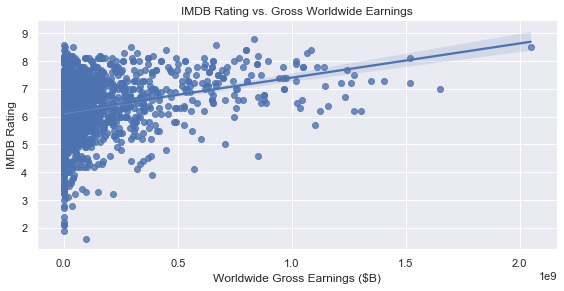

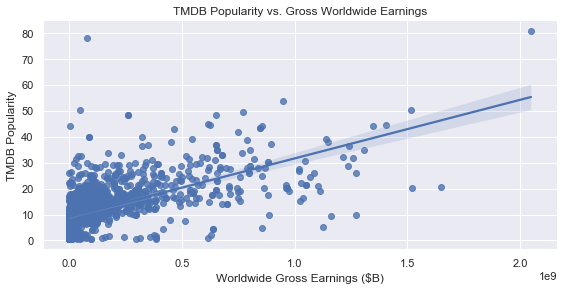

In [364]:
# IMDB Rating  vs. Gross Worldwide Earnings
sns.set(font_scale=1)
ax = sns.lmplot('worldwide_gross','averagerating_imdb', data=earnings_combo, height=4, aspect=2)
ax.set(xlabel='Worldwide Gross Earnings ($B)', ylabel='IMDB Rating', title='IMDB Rating vs. Gross Worldwide Earnings')

# TMDB Popularity vs. Gross Worldwide Earnings

ax = sns.lmplot('worldwide_gross','popularity', data=earnings_combo, height=4, aspect=2)
ax.set(xlabel='Worldwide Gross Earnings ($B)', ylabel='TMDB Popularity', title='TMDB Popularity vs. Gross Worldwide Earnings')

Popularity appears to have a more linear relationship with worldwide earnings, so we focus on this measure for the rest of the question.

### Cleaning Genres Data

In [365]:
master_imdb_tmdb = master_imdb_tmdb.rename_axis('master_id')

full_list = master_imdb_tmdb['genres'].str.split(',').apply(frozenset).to_frame(name='genres')

for genres in frozenset.union(*full_list.genres):
    full_list[genres] = full_list.apply(lambda _: int(genres in _.genres), axis=1)
    
master_imdb_tmdb = pd.merge(master_imdb_tmdb, full_list,how='left', on='master_id')


In [366]:
master_imdb_tmdb

,imdb_id,primary_title,original_title_x,start_year,runtime_minutes,genres_x,averagerating_imdb,numvotes,tmdb_id,genre_ids,...,Mystery,History,Action,Adventure,Crime,Documentary,Sport,Reality-TV,Family,Thriller
master_id,,,,,,,,,,,,,,,,,,,,,
0,1640220,Mr. Hush,Mr. Hush,2010,85,Horror,2.2,370,123389,849,...,0,0,0,0,0,0,0,0,0,0
1,1639901,A Screaming Man,Un homme qui crie,2010,92,Drama,6.7,1370,57602,789,...,0,0,0,0,0,0,0,0,0,0
2,1639426,Udaan,Udaan,2010,134,Drama,8.2,38827,45316,417,...,0,0,0,0,0,0,0,0,0,0
3,1640680,Armadillo,Armadillo,2010,105,"Documentary,War",7.5,8906,37828,3023,...,0,0,0,0,0,1,0,0,0,0
4,1641638,The Legend Is Born: Ip Man,Yip Man chin chyun,2010,100,"Action,Biography,Drama",7.1,29529,44249,928,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10430,6921996,Johnny English Strikes Again,Johnny English Strikes Again,2018,89,"Action,Adventure,Comedy",6.2,46932,463272,23860,...,0,0,1,1,0,0,0,0,0,0
10431,2837574,The Old Man & the Gun,The Old Man & the Gun,2018,93,"Biography,Comedy,Crime",6.8,25902,429203,24004,...,0,0,0,0,1,0,0,0,0,0
10432,5104604,Isle of Dogs,Isle of Dogs,2018,101,"Adventure,Animation,Comedy",7.9,108245,399174,23934,...,0,0,0,1,0,0,0,0,0,0


### Examining Genre Success

In [367]:
# Preparing Graph Data

#IMDB Rating Averages

genre_imdbscore_averages = []

for i in genre_names:
    holder = master_imdb_tmdb.loc[master_imdb_tmdb[i] == 1]
    genre_imdbscore_averages.append(holder['averagerating_imdb'].mean())

genre_imdbscore_average_df = pd.DataFrame(genre_imdbscore_averages)
genre_imdbscore_average_df = genre_imdbscore_average_df.rename(columns={0: 'averagerating_imdb'})
genre_combined_df = pd.merge(genre_names_df,genre_imdbscore_average_df,left_index=True,right_index=True).sort_values('averagerating_imdb')

# TMDB Popularity Score Average

genre_popularity_averages = []

for i in genre_names:
    holder = master_imdb_tmdb.loc[master_imdb_tmdb[i] == 1]
    genre_popularity_averages.append(holder['popularity'].mean())

genre_popularity_averages_df = pd.DataFrame(genre_popularity_averages)
genre_popularity_averages_df = genre_popularity_averages_df.rename(columns={0: 'average_popularity'})
genre_combined_df = pd.merge(genre_combined_df,genre_popularity_averages_df,left_index=True,right_index=True)


In [368]:
genre_combined_df = genre_combined_df.drop(index=0)

[Text(0, 0.5, 'Genre'),
 Text(0.5, 0, 'Average TMDB Popularity Rating'),
 Text(0.5, 1.0, 'TMDB Popularity Rating by Genre')]

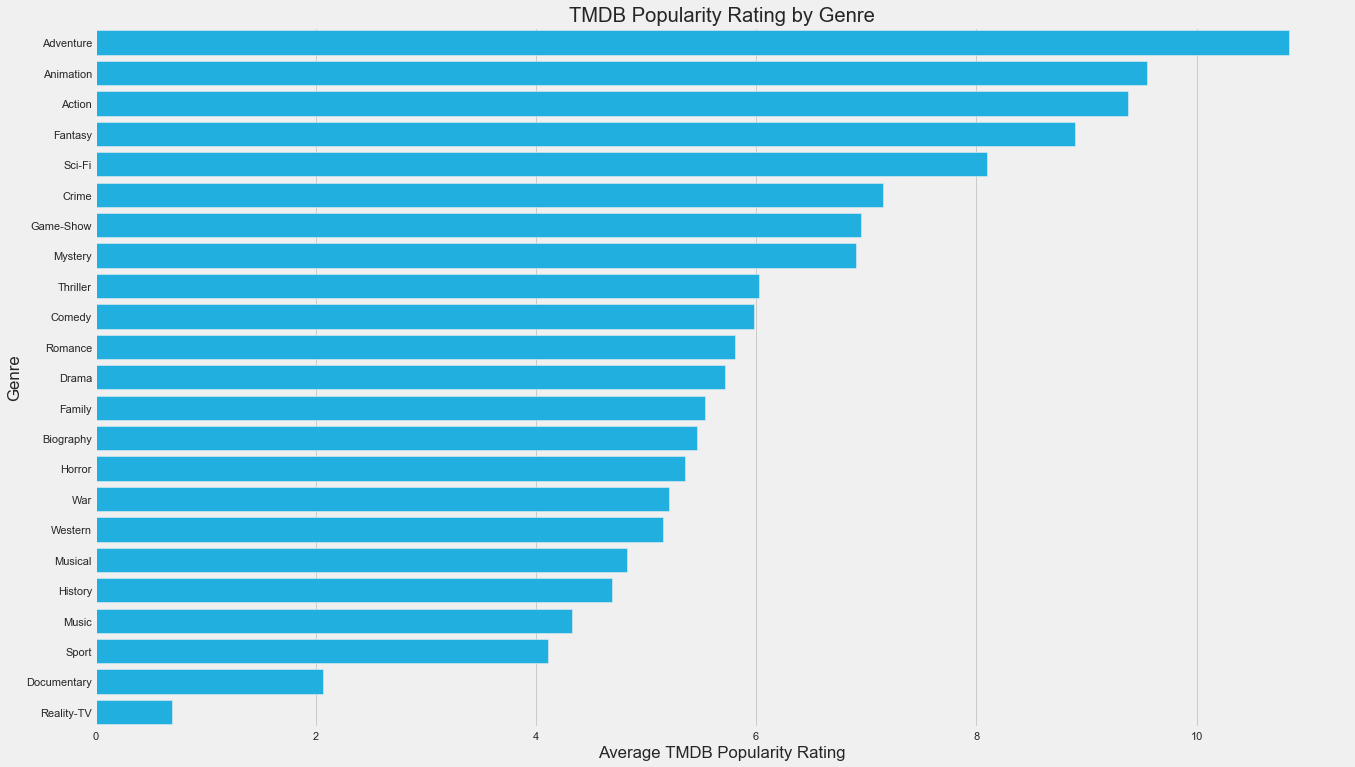

In [438]:
genre_combined_df = genre_combined_df.sort_values('average_popularity', ascending=False)
f, ax = plt.subplots(figsize=(20,12))
plt.style.use('fivethirtyeight')
sns.color_palette("YlGnBu", 10)
sns.barplot(genre_combined_df['average_popularity'],genre_combined_df['genre_name'], color='deepskyblue')
ax.set(xlabel='Average TMDB Popularity Rating', ylabel='Genre', title = 'TMDB Popularity Rating by Genre')

So it appears that adventure, animation, action, fantasy and Sci-Fi films are the most popular. 

### Distribution of Scores

Next we can examine check the distribution of scores to examine the potential 'upside'.

In [384]:
# Cleaning Data

placeholder = master_imdb_tmdb
placeholder['genres_x'] = [x.split(',') for x in placeholder['genres_x']]
placeholder = placeholder.explode('genres_x')

placeholder_1 = placeholder.loc[
    (placeholder['genres_x']=='History') |
    (placeholder['genres_x']=='Horror') |
    (placeholder['genres_x']=='Crime') |
    (placeholder['genres_x']=='Documentary') |
    (placeholder['genres_x']=='Musical')
]

placeholder_2 = placeholder.loc[
    (placeholder['genres_x']=='Adventure') |
    (placeholder['genres_x']=='Animation') |
    (placeholder['genres_x']=='Action') |
    (placeholder['genres_x']=='Fantasy') |
    (placeholder['genres_x']=='Sci-Fi')
]

[Text(0, 0, 'Horror'),
 Text(0, 0, 'Documentary'),
 Text(0, 0, 'History'),
 Text(0, 0, 'Crime'),
 Text(0, 0, 'Musical')]

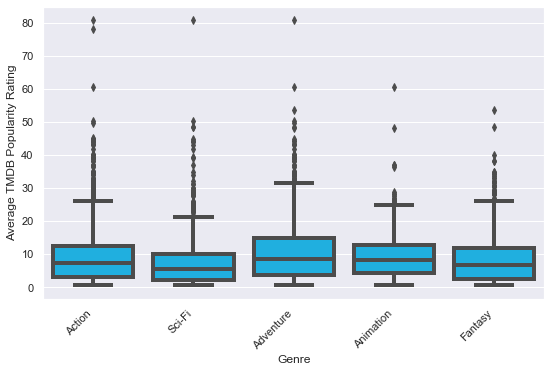

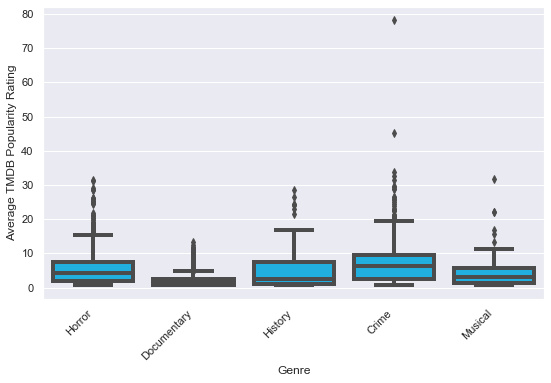

In [385]:
# Create Boxplots

sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(8,5))
plt.style.use('fivethirtyeight')
sns.color_palette("YlGnBu", 10)
sns.boxplot(placeholder_2['genres_x'],placeholder_2['popularity'], color='deepskyblue')
ax.set(xlabel='Genre', ylabel='Average TMDB Popularity Rating')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(8,5))
plt.style.use('fivethirtyeight')
sns.color_palette("YlGnBu", 10)
sns.boxplot(placeholder_1['genres_x'],placeholder_1['popularity'], color='deepskyblue')
ax.set(xlabel='Genre', ylabel='Average TMDB Popularity Rating')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

The is a far greater distribution of scores amongst the 5 selected genres - meaning there is additional upside for Microsoft.

## Sense-Check vs. IMDB

Finally, we can quickly sense check our selected findings vs. the imdb ratings data.

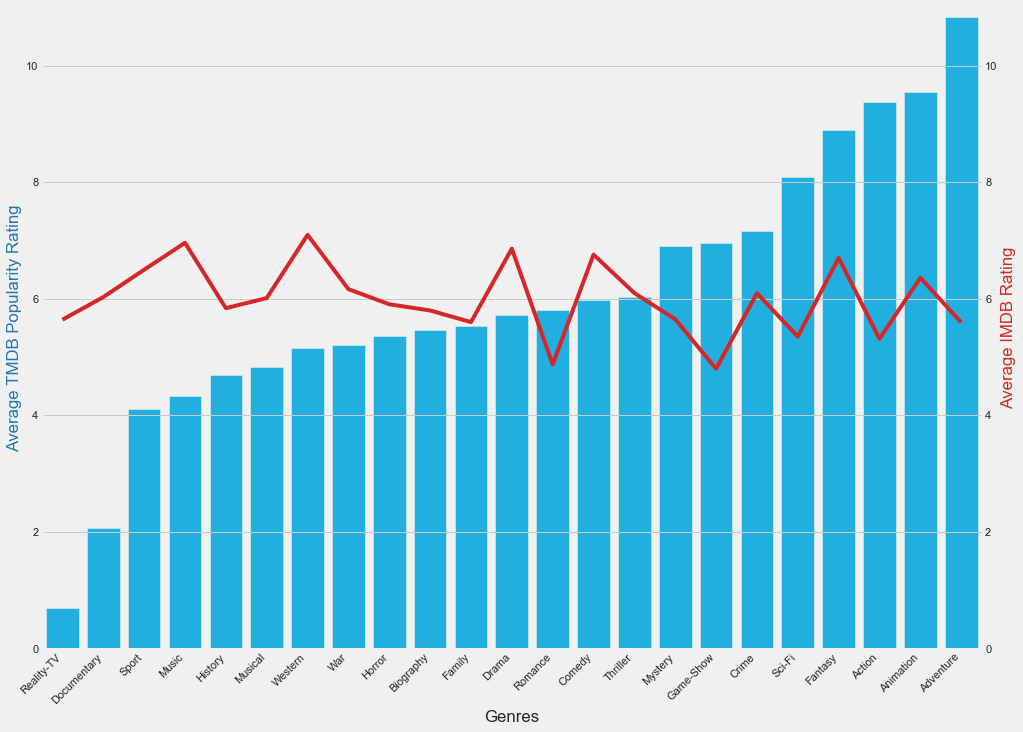

In [387]:
#COMBINED GRAPH

f, ax1 = plt.subplots(figsize=(15,11))
ax2 = ax1.twinx()
sns.lineplot(x='genre_name', y='averagerating_imdb', data = genre_combined_df, color='tab:red',ax=ax2)
sns.barplot(x='genre_name',y='average_popularity',data=genre_combined_df, color='deepskyblue',ax=ax1)

ax1.set(ylabel='Average TMDB Popularity Rating', xlabel='Genres')
ax1.set_ylabel('Average TMDB Popularity Rating', color='tab:blue')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
ax1.set_ylim(bottom=0,top=11)
ax2.set_ylabel('Average IMDB Rating', color='tab:red')
ax2.set_ylim(bottom=0,top=11)
plt.show()

Per the above, it's clear that the imdb ratings for these categories are slighly lower than others (e.g.,music). However, we stand by our recommendations, as popularity has a more linear relationship with earnings.

# What is the relationship between production budget and earnings?

[Text(0.5, 0, 'Top 10 Studios by Gross')]

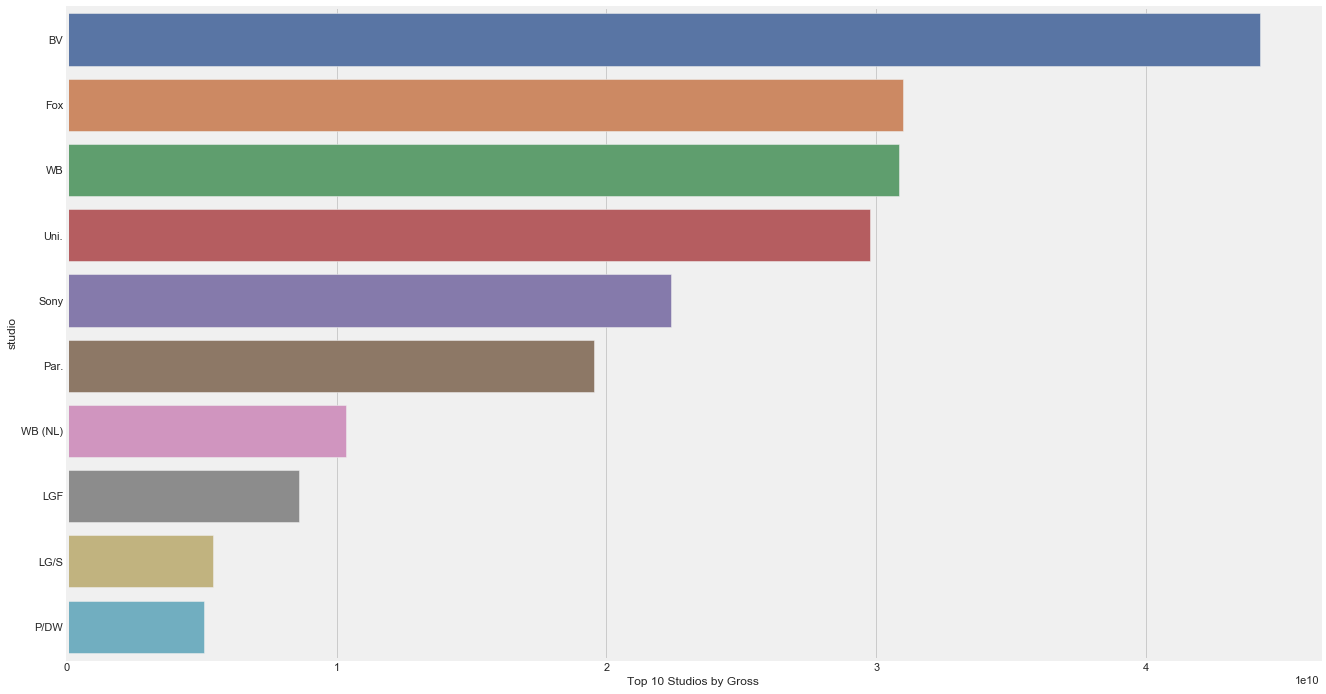

In [429]:
# Create a graph that sums the worldwide box office revenues by the Top 10 studios
bom_studio = df_bom.groupby('studio').sum().sort_values('worldwide_gross',ascending=False).head(10)

f, ax = plt.subplots(figsize=(20,12))
plt.style.use('fivethirtyeight')
sns.barplot(bom_studio['worldwide_gross'],bom_studio.index, palette='deep')
ax.set(xlabel='Top 10 Studios by Gross')

In [430]:
# Create a 'year' column by pulling the year from the release date
df_tn['year'] = df_tn['release_date'].dt.to_period('Y')

# Create a 'last_five_years' column by seeing if the movie was created after 2014
df_tn['last_five_years'] = df_tn['year'].apply(lambda x:'yes' if int(x.strftime('%Y'))>2014 else 'no')

[Text(0.5, 0, 'Top 20 movies by Worldwide Gross')]

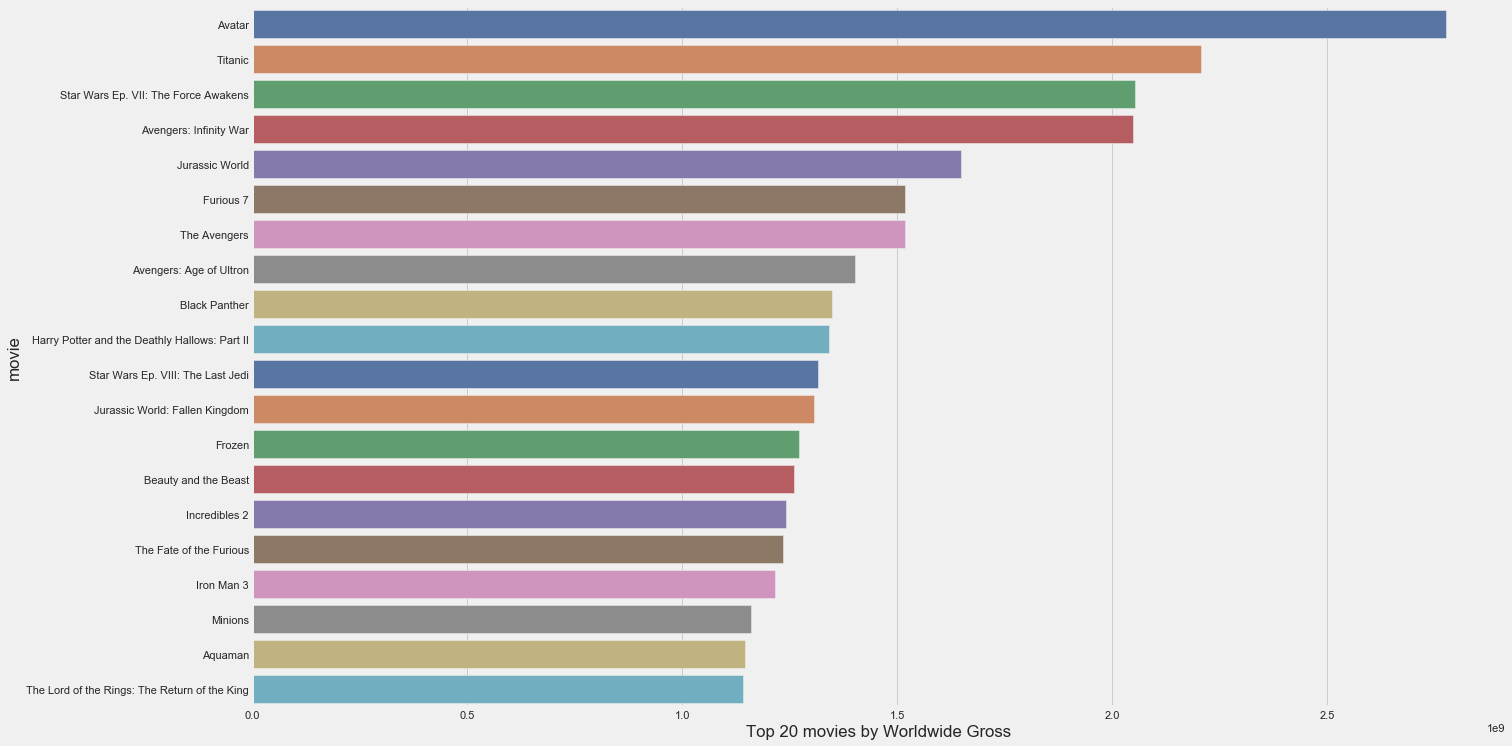

In [431]:
# Create a graph that shows the top 20 movies by Worldwide Gross
graph_tn = df_tn.sort_values('worldwide_gross',ascending=False).head(20)

f, ax = plt.subplots(figsize=(20,12))
plt.style.use('fivethirtyeight')
sns.barplot(graph_tn['worldwide_gross'],graph_tn['movie'], palette='deep')
ax.set(xlabel='Top 20 movies by Worldwide Gross')



[Text(0.5, 0, 'Top 20 movies by Foreign Gross')]

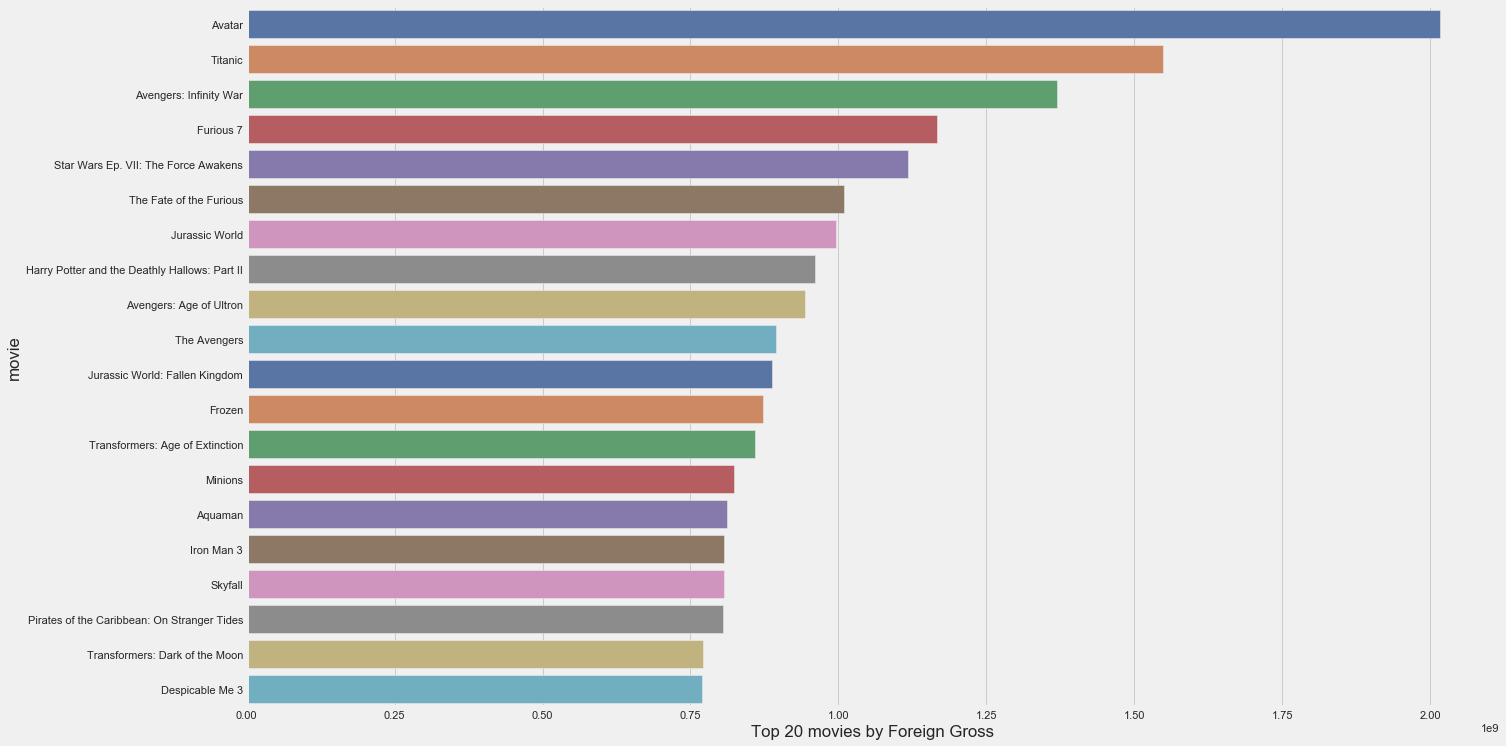

In [432]:
# Create a graph that shows the top 20 movies by Foreign Gross
graph_tn = df_tn.sort_values('foreign_gross',ascending=False).head(20)

f, ax = plt.subplots(figsize=(20,12))
plt.style.use('fivethirtyeight')
sns.barplot(graph_tn['foreign_gross'],graph_tn['movie'], palette='deep')
ax.set(xlabel='Top 20 movies by Foreign Gross')

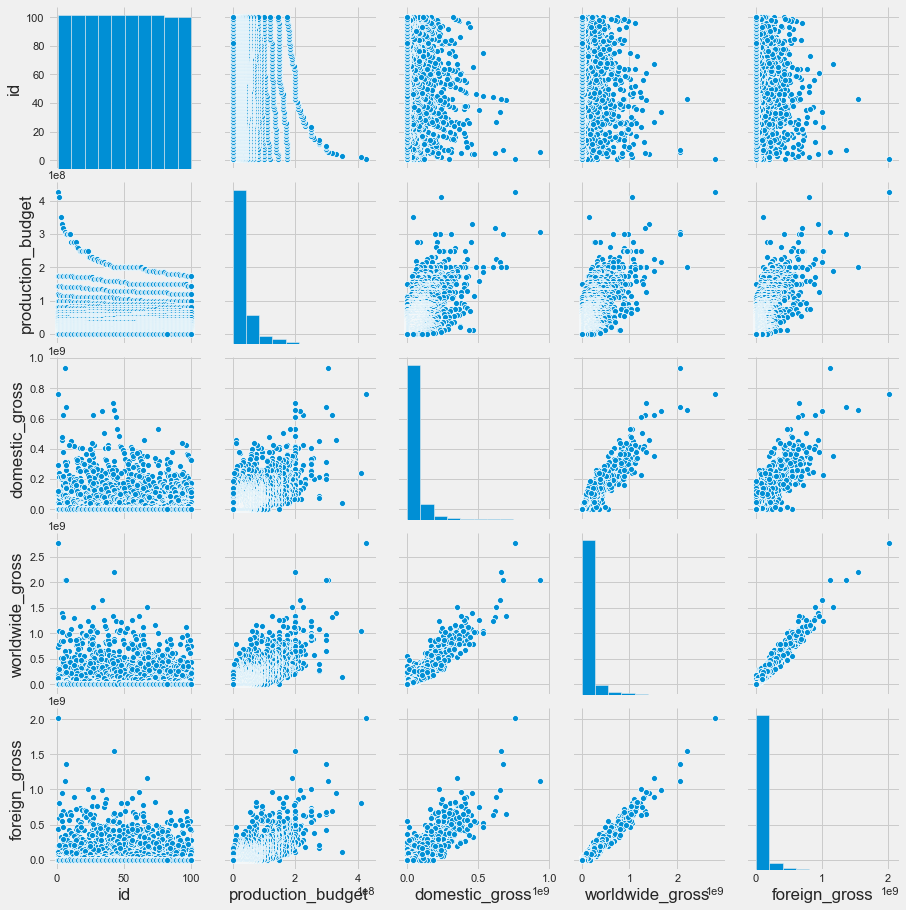

In [433]:
# Create a pairplot of the Table TN to see what relationships exist between production budget and gross revenue
sns.pairplot(df_tn)

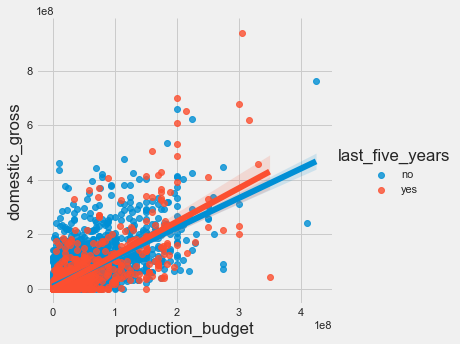

In [434]:
# Run a linear regression between production budget and domestic gross over the last 5 years
sns.lmplot('production_budget','domestic_gross', hue = 'last_five_years', data = df_tn)

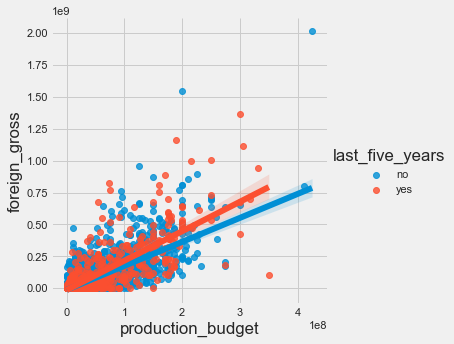

In [435]:
# Run a linear regression between production budget and foreign gross over the last 5 years
sns.lmplot('production_budget','foreign_gross', hue = 'last_five_years', data = df_tn)

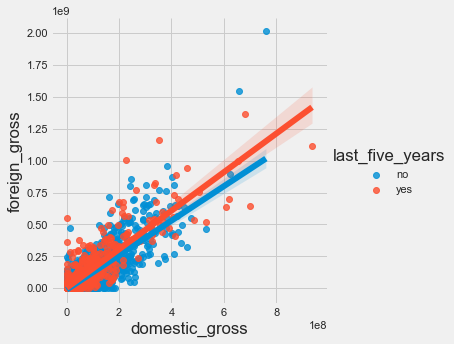

In [436]:
# Run a linear regression between domestic gross and foreign gross over the last 5 years
sns.lmplot('domestic_gross','foreign_gross',hue = 'last_five_years', data = df_tn)

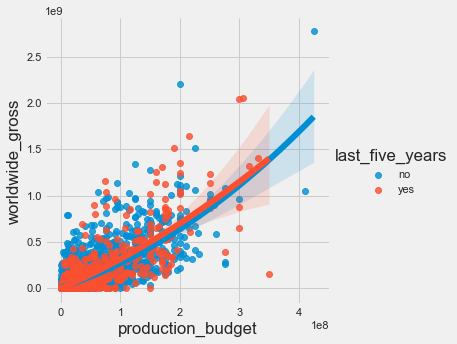

In [437]:
# Run a parabolic regression of prodution budget and worldwide_gross
sns.lmplot('production_budget','worldwide_gross', hue = 'last_five_years',order =2, ci = 95, data = df_tn)

# How do people impact the success of movies?

Finally, we wanted to explore how actors/actresses can impact movie success. To do this, we combined the IMDB 'people' data with the TMDB 'popularity' score.

### Data Cleaning

In [440]:
# Original Dataset

df_imdb_name_basics= pd.read_sql_query("""
SELECT *
FROM imdb_name_basics
;""", con)

df_imdb_name_basics.head()

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0038355,tt0117057,tt0071877,tt0037382"
1,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,producer","tt0049189,tt0057345,tt0054452,tt0059956"
2,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0069467,tt0050986,tt0083922,tt0050976"
3,nm0000006,Ingrid Bergman,1915.0,1982.0,"actress,soundtrack,producer","tt0071877,tt0036855,tt0038109,tt0038787"
4,nm0000007,Humphrey Bogart,1899.0,1957.0,"actor,soundtrack,producer","tt0034583,tt0033870,tt0037382,tt0043265"


In [391]:

#Clean Known_For Column
known_for = df_imdb_name_basics['known_for_titles'].str.split(',tt')
known_for = df_imdb_name_basics['known_for_titles'].str.replace('tt','')
known_for = known_for.str.split(',')

#Set Up Master Dictionary
master_dict = master_imdb_tmdb[['imdb_id','primary_title']].set_index('imdb_id').to_dict()['primary_title']

#Insert Cleaned Column
df_imdb_name_basics['known_for_titles_cleaned'] = known_for

#Loop Through Column and Assign Movie Names

empty_list = []

for row in df_imdb_name_basics['known_for_titles_cleaned']:
    empty_row = []
    for object in row:
        if object.isdigit():
            if int(object) in master_dict.keys():
                xyz = master_dict[int(object)]
                empty_row.append(xyz)
    empty_list.append(empty_row)

featured_movies = pd.DataFrame(empty_list,columns=['1st_movie','2nd_movie','3rd_movie','4th_movie'])

#Merge Back Into Main Table

df_imdb_name_basics = pd.merge(df_imdb_name_basics,featured_movies,left_index=True,right_index=True)

#Add Popularity for 1st,2nd,3rd,4th Movies

popularity_dict = master_imdb_tmdb[['imdb_id','popularity']].set_index('imdb_id').to_dict()['popularity']

empty_list = []

for row in df_imdb_name_basics['known_for_titles_cleaned']:
    empty_row = []
    for object in row:
        if object.isdigit():
            if int(object) in master_dict.keys():
                xyz = popularity_dict[int(object)]
                empty_row.append(xyz)
    empty_list.append(empty_row)

featured_movies_popularity = pd.DataFrame(empty_list,columns=['1st_movie_popularity','2nd_popularity','3rd_popularity','4th_popularity'])

#Merge Popularity Into Main Table

df_imdb_name_basics = pd.merge(df_imdb_name_basics,featured_movies_popularity,left_index=True,right_index=True)

#Drop Rows Where We Have No Movie Match

df_imdb_name_basics = df_imdb_name_basics.dropna(subset=['1st_movie','2nd_movie','3rd_movie','4th_movie'],how='all')

#Unpack Primary_Profession

full_profession = df_imdb_name_basics['primary_profession'].str.split(',').apply(frozenset).to_frame(name='primary_profession')
for profession in frozenset.union(*full_profession.primary_profession):
    full_profession[profession] = full_profession.apply(lambda _: int(profession in _.primary_profession), axis=1)

df_imdb_name_basics = pd.merge(df_imdb_name_basics,full_profession,left_index=True,right_index=True)

#Get Average Popularity Score
df_imdb_name_basics['average_popularity'] = df_imdb_name_basics[['1st_movie_popularity','2nd_popularity','3rd_popularity','4th_popularity']].mean(axis=1, skipna=True, numeric_only=True)

In [393]:
df_imdb_name_basics['first_profession'] = [x.split(',')[0] for x in df_imdb_name_basics['primary_profession_x']]

The actor/actress profession data is still messy. So we need a further subset to isolate those whose primary profession is acting.

In [401]:
#Clean Actors Data

actor_averages = df_imdb_name_basics.loc[
    (df_imdb_name_basics['first_profession']=='actor') & 
    (df_imdb_name_basics['stunts']==0) &
    (df_imdb_name_basics['camera_department']==0) &
    (df_imdb_name_basics['sound_department']==0) &
    (df_imdb_name_basics['miscellaneous']==0) &
    (df_imdb_name_basics['2nd_popularity']>0) &
    (df_imdb_name_basics['average_popularity']>30)]

actor_averages = actor_averages.sort_values('average_popularity',ascending=False).head(20)
actor_averages['birth_year'] = actor_averages['birth_year'].astype(str)
actor_averages['graph_name'] = actor_averages['primary_name'] + ' (' + actor_averages['1st_movie']+')'


In [408]:
#Clean Actresses Data

actress_averages = df_imdb_name_basics.loc[
    (df_imdb_name_basics['first_profession']=='actress') & 
    (df_imdb_name_basics['stunts']==0) &
    (df_imdb_name_basics['camera_department']==0) &
    (df_imdb_name_basics['sound_department']==0) &
    (df_imdb_name_basics['miscellaneous']==0) &
    (df_imdb_name_basics['2nd_popularity']>0) &
    (df_imdb_name_basics['average_popularity']>30)]

actress_averages = actress_averages.sort_values('average_popularity',ascending=False).head(20)

### Examine Top Actors

[Text(0, 0.5, 'Actor Name'),
 Text(0.5, 0, 'Average TMDB Popularity Rating Across Their Movies')]

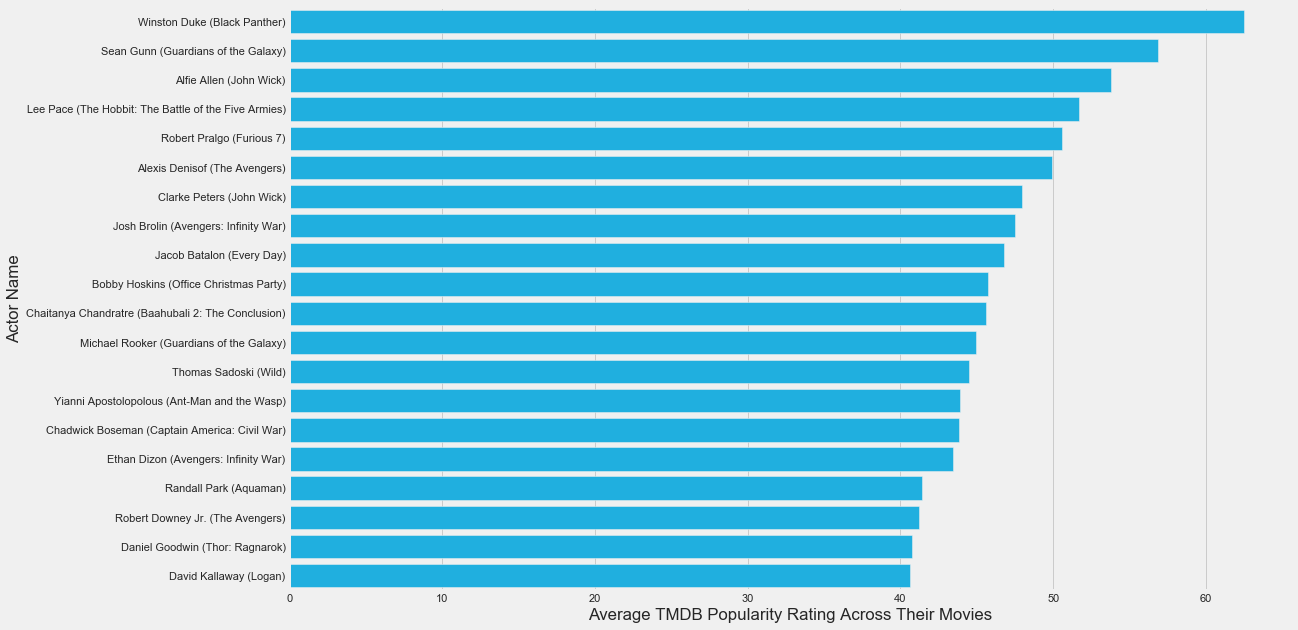

In [409]:
#Create Actors Graph

f, ax = plt.subplots(figsize=(16,10))
plt.style.use('fivethirtyeight')
sns.barplot(actor_averages['average_popularity'],actor_averages['graph_name'], color = 'deepskyblue')
ax.set(xlabel='Average TMDB Popularity Rating Across Their Movies',ylabel='Actor Name')

The top 3 actors that Microsoft should work with are: Winston Duke, Sean Gunn and Alfie Allen

![Winston Duke](https://cdn1.thr.com/sites/default/files/imagecache/768x433/2018/05/gettyimages-950537920_copy.jpg)

![Sean Gunn](https://cdn.flickeringmyth.com/wp-content/uploads/2019/03/guardians-of-the-galaxy-kraglin-600x347.jpg)

![Alfie Allen](https://www.indiewire.com/wp-content/uploads/2019/09/669b7918-e5d5-476e-93cc-8997a085ebb1.sized-1000x1000.jpg)


## Examine Top Actresses

[Text(0, 0.5, 'Actress Name'),
 Text(0.5, 0, 'Average TMDB Popularity Rating Across Their Movies')]

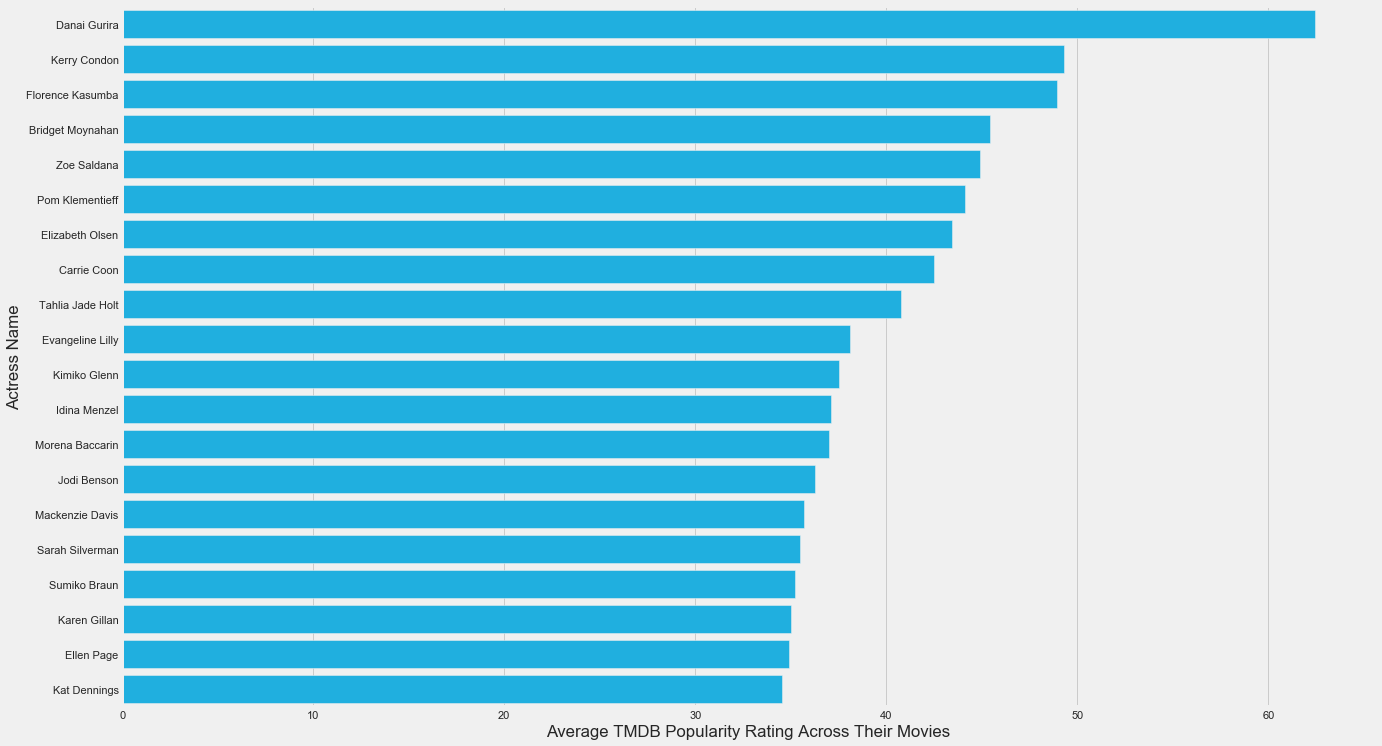

In [410]:
#Create Actress Graph

f, ax = plt.subplots(figsize=(20,12))
plt.style.use('fivethirtyeight')
sns.barplot(actress_averages['average_popularity'],actress_averages['primary_name'], color='deepskyblue')
ax.set(xlabel='Average TMDB Popularity Rating Across Their Movies',ylabel='Actress Name')

So the top 3 actresses Microsoft should hire are Danai Gurira, Kerry Condon and Florence Kasumba!

![Danai Gurira](https://vignette.wikia.nocookie.net/walkingdead/images/8/84/Danai_grira_2019.jpg/revision/latest/scale-to-width-down/350?cb=20181203012805)

![Kerry Condon](https://vignette.wikia.nocookie.net/marvelcinematicuniverse/images/e/e4/Kerry_Condon.jpg/revision/latest/scale-to-width-down/310?cb=20190424140103)

![Florence Kasumba](https://vignette.wikia.nocookie.net/marvelcinematicuniverse/images/f/fe/Florence_Kasumba.jpg/revision/latest/scale-to-width-down/310?cb=20180130133532)

# Recommendation Summary

To summarize, we found the following:
    
- Movie ratings may not be the best indicator indicator of commericial success. Therefore, Microsoft should focus on the action,adventure, sci-fi, animation and fantasy genres
- There is a correlation between box office success and larger production budgets. Many of these films tend to Disney films. Therefore, Microsoft should focus on larger production budget films
- Some actors/actresses have a strong track record of producing very popular films. Therefore, Microsoft should aim to hire: Winston Duke, Sean Gunn, Alfie Allen, Danai Gurira, Kerry Condon and Florence Kasumba.

# Next Steps

If we had more time, we would do the following:
    
- Do a deep-dive on Disney movies to determine why they are so successful
- Explore data from streaming platforms to better improve the popularity measure
- Explore non-traditional sources of data (e.g., scrapping sentiment from Twitter)
- Expand size of datasets (esp. RT) and examine the trends over time
- Analyse the data to help Microsoft come up with a content acquisition strategy (i.e., build vs. buy)